In [3]:
# Libraries
import numpy as np
from numpy.fft import fftn, ifftn, fftshift
import matplotlib.pyplot as plt
import os
import imageio
from scipy.stats import norm
from scipy.ndimage import gaussian_filter1d

In [7]:
# ================================ FUNCTION FOR PLURIGAUSSIAN =======================================
# 1. Calculating the estimators from data including volume fraction of phasese eps_i, two-point coverage probability functions ≡ non-centred covariance functions C_{ii}
def epsilon_V(I):                       # volume fraction
    width, height, depth = I.shape
    a_v = width * height * depth
    a_pore = np.sum(I == 0)
    a_solid = np.sum(I == 1)
    nf = a_pore/a_v
    ns = a_solid/a_v
    return nf, ns

def lambda_i(eps_i):                    # threshold of a phase
    return norm.ppf(eps_i)              # percent point function, i.e., the inverse cumulative distribution function (CDF)

def two_point_correlation(I):
    """
    Compute two-point coverage probability using FFT.
    -----------
        I : Binary 2D or 3D array representing the microstructure.
            Values should be 0 or 1 (e.g., 0 = pore, 1 = solid).
    Returns:
        C : Two-point coverage probability (autocorrelation) array of same shape as I.
            Center of the array corresponds to lag 0.
    """
    I = I.astype(float)
    F = fftn(I)                         # FFT
    C = np.real(ifftn(F * np.conj(F)))
    C /= np.prod(I.shape)               # Normalize by total number of points
    C = fftshift(C)                     # Shift zero lag to center (optional)
    return C

def radial_average(C, h_max):
    nx, ny, nz = C.shape
    cx, cy, cz = nx//2, ny//2, nz//2

    x, y, z = np.indices(C.shape)
    r = np.sqrt((x-cx)**2 + (y-cy)**2 + (z-cz)**2)
    r = r.astype(int)
    C_iso = np.zeros(h_max)
    for i in range(h_max):
        mask = (r == i)
        C_iso[i] = C[mask].mean() if np.any(mask) else np.nan
    return C_iso

def directional_correlations(C):
    """
    Extract directional two-point correlations along principal axes.
    For checking anisotropy: if C_x, C_y, C_z are similar, material is isotropic.
    If they differ, material is anisotropic.
    
    Parameters:
        C : 3D autocorrelation array (centered)
    
    Returns:
        C_x, C_y, C_z : 1D arrays of correlations along each axis
    """
    nx, ny, nz = C.shape
    cx, cy, cz = nx//2, ny//2, nz//2
    
    # Extract along x-axis (keeping y, z at center)
    C_x = C[:, cy, cz]
    
    # Extract along y-axis (keeping x, z at center)
    C_y = C[cx, :, cz]
    
    # Extract along z-axis (keeping x, y at center)
    C_z = C[cx, cy, :]
    
    return C_x, C_y, C_z

Processing 197 folders...
  Error processing folder 0: [WinError 3] The system cannot find the path specified: 'D:\\data\\data3d200\\0'


C:\Users\phu.thien.nguyen\AppData\Local\Temp\ipykernel_25212\670559425.py:26: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  sample = imageio.imread(os.path.join(folder_path, file_list[0]))
C:\Users\phu.thien.nguyen\AppData\Local\Temp\ipykernel_25212\670559425.py:32: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  M_pore[i] = imageio.imread(os.path.join(folder_path, fname))


  Processed 20/197 folders
  Processed 40/197 folders
  Processed 60/197 folders
  Processed 80/197 folders
  Processed 100/197 folders
  Processed 120/197 folders
  Processed 140/197 folders
  Processed 160/197 folders
  Processed 180/197 folders
Successfully processed 196 folders


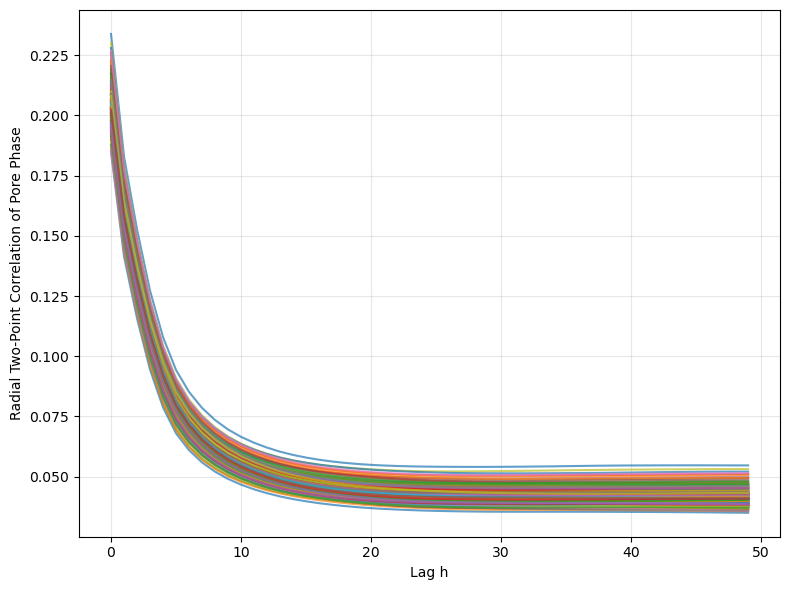

In [8]:
# Process all 197 folders and collect C_11_h curves
base_path = r"D:\data\data3d200"
h_max = 50
num_folders = 197

# Dictionary to store C_11_h for each folder
C_11_h_dict = {}
h = np.arange(h_max)

print("Processing 197 folders...")
for folder_num in range(num_folders):
    folder_path = os.path.join(base_path, str(folder_num))
    
    try:
        # Get a sorted list of all image files
        file_list = sorted(
            [f for f in os.listdir(folder_path) if f.endswith(".bmp")],
            key=lambda fname: int(os.path.splitext(fname)[0])
        )
        
        if not file_list:
            print(f"  Folder {folder_num}: No BMP files found")
            continue
        
        # Read first image to get shape
        sample = imageio.imread(os.path.join(folder_path, file_list[0]))
        H, W = sample.shape
        
        # Load all images
        M_pore = np.zeros((len(file_list), H, W), dtype=sample.dtype)
        for i, fname in enumerate(file_list):
            M_pore[i] = imageio.imread(os.path.join(folder_path, fname))
        
        M_pore = M_pore.astype(np.uint8)
        
        # Calculate two-point correlation and radial average
        C_11 = two_point_correlation(M_pore)
        C_11_h_dict[folder_num] = radial_average(C_11, h_max)
        
        if (folder_num + 1) % 20 == 0:
            print(f"  Processed {folder_num + 1}/{num_folders} folders")
    
    except Exception as e:
        print(f"  Error processing folder {folder_num}: {str(e)}")
        continue

print(f"Successfully processed {len(C_11_h_dict)} folders")

# Plot all C_11_h curves
plt.figure(figsize=(8, 6))
for folder_num in sorted(C_11_h_dict.keys()):
    plt.plot(h, C_11_h_dict[folder_num], label=f"Folder {folder_num}", alpha=0.7)

plt.xlabel("Lag h")
plt.ylabel("Radial Two-Point Correlation of Pore Phase")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

Processing 197 folders for directional correlations...
  Error processing folder 0: [WinError 3] The system cannot find the path specified: 'D:\\data\\data3d200\\0'


C:\Users\phu.thien.nguyen\AppData\Local\Temp\ipykernel_25212\274416669.py:31: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  sample = imageio.imread(os.path.join(folder_path, file_list[0]))
C:\Users\phu.thien.nguyen\AppData\Local\Temp\ipykernel_25212\274416669.py:37: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  M_pore[i] = imageio.imread(os.path.join(folder_path, fname))


  Processed 20/197 folders
  Processed 40/197 folders
  Processed 60/197 folders
  Processed 80/197 folders
  Processed 100/197 folders
  Processed 120/197 folders
  Processed 140/197 folders
  Processed 160/197 folders
  Processed 180/197 folders
Successfully processed 196 folders


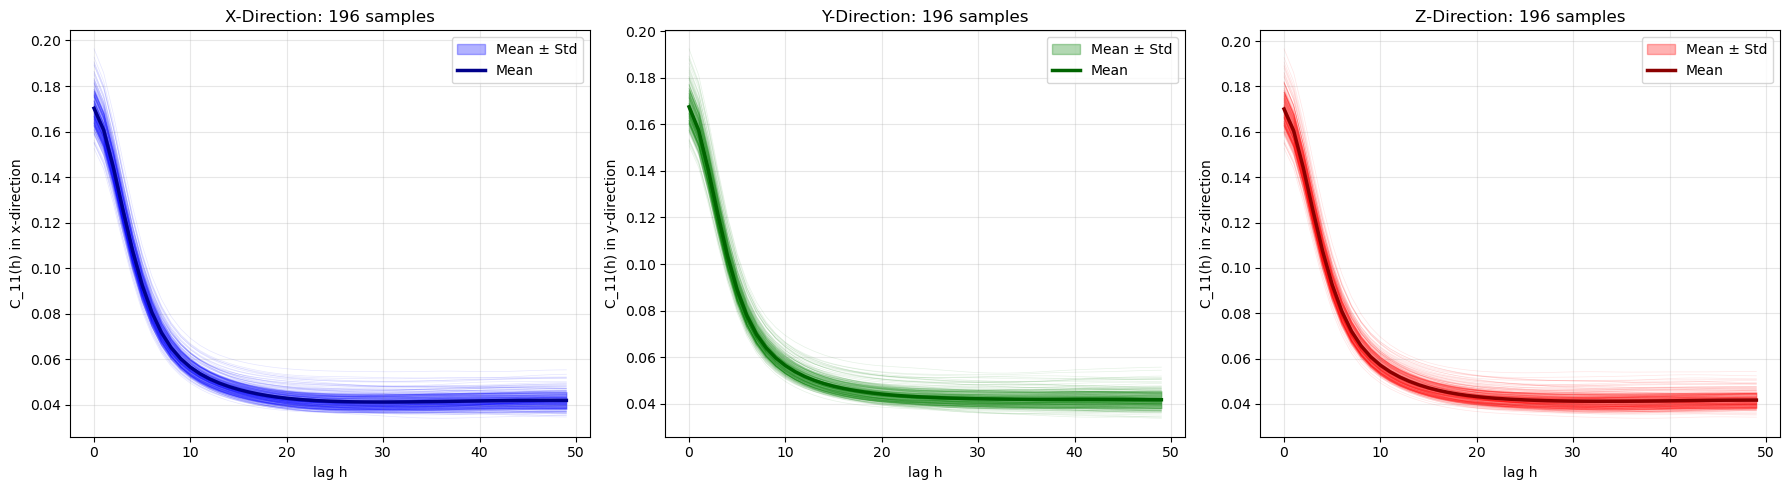


Directional correlation data stored in:
  C_x_dict, C_y_dict, C_z_dict (individual samples)
  C_x_array, C_y_array, C_z_array (numpy arrays)


In [9]:
# Process all 197 folders and collect DIRECTIONAL correlations (C_x, C_y, C_z)
from scipy.ndimage import gaussian_filter1d

base_path = r"D:\data\data3d200"
h_max = 50
num_folders = 197
kernel_std = 2.0  # Standard deviation for Gaussian kernel

# Dictionaries to store directional correlations for each folder
C_x_dict = {}
C_y_dict = {}
C_z_dict = {}
h = np.arange(h_max)

print("Processing 197 folders for directional correlations...")
for folder_num in range(num_folders):
    folder_path = os.path.join(base_path, str(folder_num))
    
    try:
        # Get a sorted list of all image files
        file_list = sorted(
            [f for f in os.listdir(folder_path) if f.endswith(".bmp")],
            key=lambda fname: int(os.path.splitext(fname)[0])
        )
        
        if not file_list:
            print(f"  Folder {folder_num}: No BMP files found")
            continue
        
        # Read first image to get shape
        sample = imageio.imread(os.path.join(folder_path, file_list[0]))
        H, W = sample.shape
        
        # Load all images
        M_pore = np.zeros((len(file_list), H, W), dtype=sample.dtype)
        for i, fname in enumerate(file_list):
            M_pore[i] = imageio.imread(os.path.join(folder_path, fname))
        
        M_pore = M_pore.astype(np.uint8)
        
        # Calculate two-point correlation (full 3D)
        C_11 = two_point_correlation(M_pore)
        
        # Extract directional correlations
        C_x, C_y, C_z = directional_correlations(C_11)
        
        # Get center and extract profiles
        nx, ny, nz = C_11.shape
        cx, cy, cz = nx//2, ny//2, nz//2
        
        # Apply Gaussian smoothing to directional profiles
        C_x_dict[folder_num] = gaussian_filter1d(C_x[cx:cx+h_max], sigma=kernel_std)
        C_y_dict[folder_num] = gaussian_filter1d(C_y[cy:cy+h_max], sigma=kernel_std)
        C_z_dict[folder_num] = gaussian_filter1d(C_z[cz:cz+h_max], sigma=kernel_std)
        
        if (folder_num + 1) % 20 == 0:
            print(f"  Processed {folder_num + 1}/{num_folders} folders")
    
    except Exception as e:
        print(f"  Error processing folder {folder_num}: {str(e)}")
        continue

print(f"Successfully processed {len(C_x_dict)} folders")

# Convert to arrays for statistical analysis
C_x_array = np.array([C_x_dict[i] for i in sorted(C_x_dict.keys())])
C_y_array = np.array([C_y_dict[i] for i in sorted(C_y_dict.keys())])
C_z_array = np.array([C_z_dict[i] for i in sorted(C_z_dict.keys())])

# Calculate mean and std for each direction
C_x_mean = np.mean(C_x_array, axis=0)
C_x_std = np.std(C_x_array, axis=0)

C_y_mean = np.mean(C_y_array, axis=0)
C_y_std = np.std(C_y_array, axis=0)

C_z_mean = np.mean(C_z_array, axis=0)
C_z_std = np.std(C_z_array, axis=0)

# Plot three separate graphs for C_x, C_y, C_z
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# C_x plot
axes[0].fill_between(h, C_x_mean - C_x_std, C_x_mean + C_x_std, 
                      alpha=0.3, color='blue', label='Mean ± Std')
for folder_num in sorted(C_x_dict.keys()):
    axes[0].plot(h, C_x_dict[folder_num], alpha=0.1, color='blue', linewidth=0.5)
axes[0].plot(h, C_x_mean, color='darkblue', linewidth=2.5, label='Mean', zorder=10)
axes[0].set_xlabel("lag h")
axes[0].set_ylabel("C_11(h) in x-direction")
axes[0].set_title(f"X-Direction: {len(C_x_dict)} samples")
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# C_y plot
axes[1].fill_between(h, C_y_mean - C_y_std, C_y_mean + C_y_std, 
                      alpha=0.3, color='green', label='Mean ± Std')
for folder_num in sorted(C_y_dict.keys()):
    axes[1].plot(h, C_y_dict[folder_num], alpha=0.1, color='green', linewidth=0.5)
axes[1].plot(h, C_y_mean, color='darkgreen', linewidth=2.5, label='Mean', zorder=10)
axes[1].set_xlabel("lag h")
axes[1].set_ylabel("C_11(h) in y-direction")
axes[1].set_title(f"Y-Direction: {len(C_y_dict)} samples")
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# C_z plot
axes[2].fill_between(h, C_z_mean - C_z_std, C_z_mean + C_z_std, 
                      alpha=0.3, color='red', label='Mean ± Std')
for folder_num in sorted(C_z_dict.keys()):
    axes[2].plot(h, C_z_dict[folder_num], alpha=0.1, color='red', linewidth=0.5)
axes[2].plot(h, C_z_mean, color='darkred', linewidth=2.5, label='Mean', zorder=10)
axes[2].set_xlabel("lag h")
axes[2].set_ylabel("C_11(h) in z-direction")
axes[2].set_title(f"Z-Direction: {len(C_z_dict)} samples")
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nDirectional correlation data stored in:")
print(f"  C_x_dict, C_y_dict, C_z_dict (individual samples)")
print(f"  C_x_array, C_y_array, C_z_array (numpy arrays)")

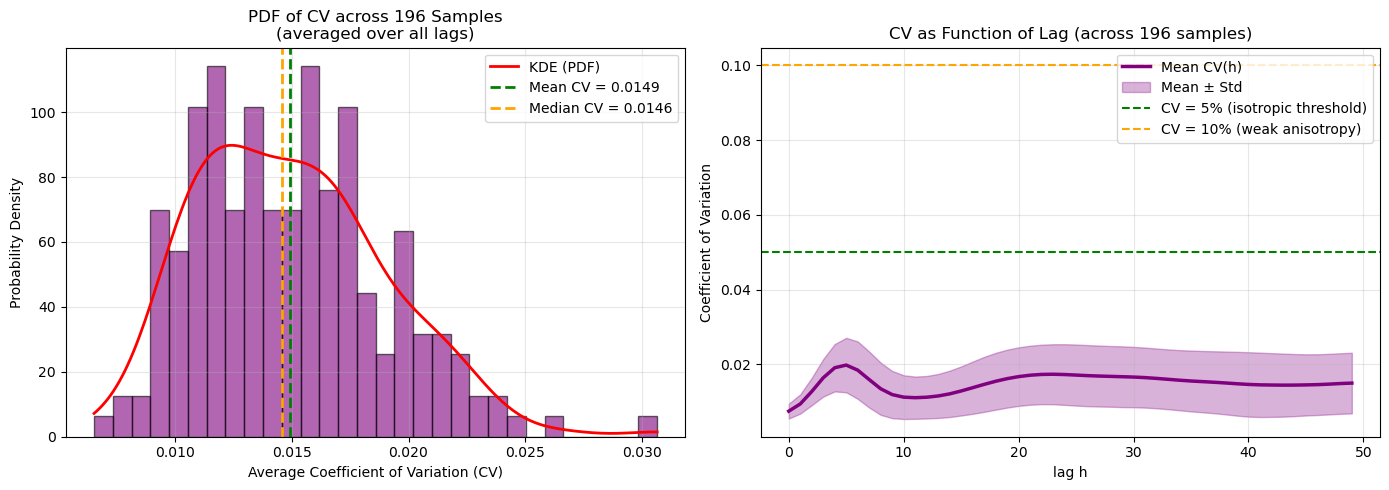


=== COEFFICIENT OF VARIATION STATISTICS ===

Across all 196 samples (averaged over all lags):
  Mean CV:     0.014938  (1.49%)
  Median CV:   0.014571  (1.46%)
  Std of CV:   0.004027
  Min CV:      0.006516  (0.65%)
  Max CV:      0.030660  (3.07%)

INTERPRETATION (based on average CV):
✓ ISOTROPIC: Mean CV < 5%
  → Material shows isotropic behavior across samples
  → Radial averaging is statistically justified


In [10]:
# Calculate and plot PDF of Coefficient of Variation across directions for 197 samples
from scipy import stats

# Calculate CV for each sample at each lag h
# CV at each h = std(C_x, C_y, C_z) / mean(C_x, C_y, C_z)
num_samples = len(C_x_dict)
CV_per_sample = np.zeros((num_samples, h_max))

for idx, folder_num in enumerate(sorted(C_x_dict.keys())):
    # Stack the three directional values at each lag
    C_stack = np.vstack([C_x_dict[folder_num], 
                         C_y_dict[folder_num], 
                         C_z_dict[folder_num]])
    
    # Calculate mean and std across directions at each lag
    mean_at_h = C_stack.mean(axis=0)
    std_at_h = C_stack.std(axis=0)
    
    # Coefficient of variation at each lag
    CV_per_sample[idx, :] = std_at_h / (mean_at_h + 1e-10)

# Calculate average CV across all lags for each sample
CV_avg_per_sample = CV_per_sample.mean(axis=1)

# Plot 1: PDF/Histogram of average CV across samples
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram with KDE
axes[0].hist(CV_avg_per_sample, bins=30, density=True, alpha=0.6, color='purple', edgecolor='black')

# Fit and plot KDE (kernel density estimation)
kde = stats.gaussian_kde(CV_avg_per_sample)
x_range = np.linspace(CV_avg_per_sample.min(), CV_avg_per_sample.max(), 200)
axes[0].plot(x_range, kde(x_range), 'r-', linewidth=2, label='KDE (PDF)')

axes[0].axvline(CV_avg_per_sample.mean(), color='green', linestyle='--', linewidth=2, 
                label=f'Mean CV = {CV_avg_per_sample.mean():.4f}')
axes[0].axvline(np.median(CV_avg_per_sample), color='orange', linestyle='--', linewidth=2,
                label=f'Median CV = {np.median(CV_avg_per_sample):.4f}')

axes[0].set_xlabel("Average Coefficient of Variation (CV)")
axes[0].set_ylabel("Probability Density")
axes[0].set_title(f"PDF of CV across {num_samples} Samples\n(averaged over all lags)")
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot 2: CV as function of lag h (mean ± std across samples)
CV_mean_vs_h = CV_per_sample.mean(axis=0)
CV_std_vs_h = CV_per_sample.std(axis=0)

axes[1].plot(h, CV_mean_vs_h, color='purple', linewidth=2.5, label='Mean CV(h)')
axes[1].fill_between(h, CV_mean_vs_h - CV_std_vs_h, CV_mean_vs_h + CV_std_vs_h,
                      alpha=0.3, color='purple', label='Mean ± Std')
axes[1].axhline(0.05, color='green', linestyle='--', linewidth=1.5, label='CV = 5% (isotropic threshold)')
axes[1].axhline(0.10, color='orange', linestyle='--', linewidth=1.5, label='CV = 10% (weak anisotropy)')

axes[1].set_xlabel("lag h")
axes[1].set_ylabel("Coefficient of Variation")
axes[1].set_title(f"CV as Function of Lag (across {num_samples} samples)")
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print statistics
print("\n=== COEFFICIENT OF VARIATION STATISTICS ===")
print(f"\nAcross all {num_samples} samples (averaged over all lags):")
print(f"  Mean CV:     {CV_avg_per_sample.mean():.6f}  ({100*CV_avg_per_sample.mean():.2f}%)")
print(f"  Median CV:   {np.median(CV_avg_per_sample):.6f}  ({100*np.median(CV_avg_per_sample):.2f}%)")
print(f"  Std of CV:   {CV_avg_per_sample.std():.6f}")
print(f"  Min CV:      {CV_avg_per_sample.min():.6f}  ({100*CV_avg_per_sample.min():.2f}%)")
print(f"  Max CV:      {CV_avg_per_sample.max():.6f}  ({100*CV_avg_per_sample.max():.2f}%)")

# Interpretation
print(f"\n{'='*60}")
print("INTERPRETATION (based on average CV):")
print(f"{'='*60}")
mean_cv = CV_avg_per_sample.mean()
if mean_cv < 0.05:
    print("✓ ISOTROPIC: Mean CV < 5%")
    print("  → Material shows isotropic behavior across samples")
    print("  → Radial averaging is statistically justified")
elif mean_cv < 0.10:
    print("≈ WEAKLY ANISOTROPIC: 5% < Mean CV < 10%")
    print("  → Material shows weak directional preference")
    print("  → Radial averaging acceptable with caution")
else:
    print("✗ ANISOTROPIC: Mean CV > 10%")
    print("  → Material shows significant directional dependence")
    print("  → Must use directional correlations (C_x, C_y, C_z) separately")

In [ ]:

# -----------------------------
# Parameters
# -----------------------------
tau_max = 100  # max lag

nx, ny, nz = Rho_tau.shape
cx, cy, cz = nx//2, ny//2, nz//2

# -----------------------------
# Bivariate normal PDF and integral
# -----------------------------
def phi(lambda_1, gamma):
    return 1/(2*np.pi*np.sqrt(1-gamma**2)) * np.exp(-lambda_1**2 * (1-gamma)/(1-gamma**2))

def F(rho):
    integral_val, _ = quad(lambda gamma: phi(lambda_1, gamma), 0, rho)
    return integral_val

F_max = F(0.999)
F_min = 0

# -----------------------------
# Function to compute The correlation function of the latent Gaussian field along a given 1D covariance
# -----------------------------
def compute_rho_G(Rho_ii):
    rho_G = []
    for Rho_val in Rho_ii:
        target = np.clip(Rho_val, F_min, F_max)
        sol = root_scalar(lambda rho: F(rho) - target, bracket=[0, 0.999], method='bisect')
        rho_G.append(sol.root)
    return np.array(rho_G)

# -----------------------------
# Extract positive lags along x, y, z
# -----------------------------
Rho_11 = Rho_tau[cx:cx+tau_max , cy, cz]
Rho_22 = Rho_tau[cx, cy:cy+tau_max , cz]
Rho_33 = Rho_tau[cx, cy, cz:cz+tau_max ]

# Compute rho_X for all directions
rho_G_11 = compute_rho_G(Rho_11)
rho_G_22 = compute_rho_G(Rho_22)
rho_G_33 = compute_rho_G(Rho_33)

# -----------------------------
# Plot rho_X(h) in all directions
# -----------------------------
tau_vals = np.arange(tau_max)

plt.figure(figsize=(8,5))
plt.plot(tau_vals, rho_G_11,'go--',  color='blue', marker='o', linewidth=2, label='$\\rho_{11}(h)$', markersize=3)
plt.plot(tau_vals, rho_G_22,'g-', color='red', marker='s', linewidth=2, label='$\\rho_{22}(h)$', markersize=3)
plt.plot(tau_vals, rho_G_33,  color='black', marker='^', linewidth=2, label='$\\rho_{33}(h)$', markersize=3)
plt.xlabel('Lag h (voxels)', fontsize=11)
plt.ylabel('$\\rho_X(h)$', fontsize=11)
plt.title('Gaussian Correlation Function in Three Directions', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# -----------------------------
# Print first 10 values for each direction
# -----------------------------
print("First 10 rho_X values:")
for tau in range(10):
    print(f"h={tau}: x={rho_G_11[tau]:.6f}, y={rho_G_22[tau]:.6f}, z={rho_G_33[tau]:.6f}")
